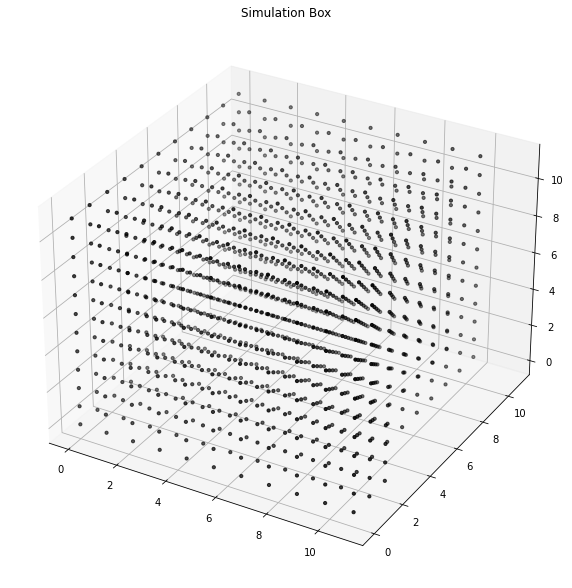

In [43]:
import numpy as np
import matplotlib.pyplot as plt

L = 12  # length of cell
N = 1348  # number of atoms
mdts = 5000  # number of time steps
dt = 0.01  # time step
dr = 0.1  # delta r for RDF
T = 1.25  # temperature

p = np.zeros((N, 3))
# Generate regular initial locations of each particle in the cell
nop = 0
for x in range(11):
    for y in range(11):
        for z in range(12):
            if nop < N:
                p[nop] = np.array([x * 1.091, y * 1.091, z])
                nop += 1
# Plotting the simulation box
fig = plt.figure(figsize=(10,11))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p[:, 0], p[:, 1], p[:, 2], s=10, c='black')
ax.set_title('Simulation Box')
plt.show()

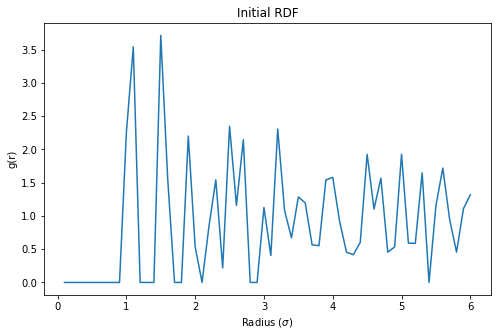

In [44]:
np.random.seed(0)  # Seed for reproducibility

# give an initial velocity to all
v = np.random.rand(N, 3) - 0.5
vi_squared = np.sum(v**2, axis=1)
ktd = np.sum(vi_squared)
# Correction of initial velocity
cf = np.sqrt((3 * N * T) / ktd)
v *= cf

# Compute differences
delta_xyz = p[:, None, :] - p[None, :, :]
delta_xyz -= L * np.round(delta_xyz / L)

rx = delta_xyz[:, :, 0]
ry = delta_xyz[:, :, 1]
rz = delta_xyz[:, :, 2]

# Compute distances
r = np.sqrt(rx**2 + ry**2 + rz**2)

# Compute potential energy incrementally
mask = np.logical_and((r <= 2.5),(r>0))
uE = np.sum(2 * ((1 / r[mask] ** 12) - 1 / r[mask] ** 6 - (1 / 2.5 ** 12) + 1 / 2.5 ** 6))

# Calculate the number of atom at different radius
Radius = np.arange(0.1, 6.1, 0.1)
grinit = np.zeros(60)
for i in range(1, 61):
    mask = np.logical_and(r <= i * dr, r > (i - 1) * dr)
    sp = np.sum(np.triu(mask, k=1))
    grinit[i - 1] = sp * 3 * L ** 3 / (2 * np.pi * N * (N - 1) * ((i * dr) ** 3 - ((i - 1) * dr) ** 3))
        
# Plotting RDF
plt.figure(figsize=(8,5))
plt.plot(Radius, grinit)
plt.title('Initial RDF')
plt.xlabel('Radius ($\sigma$)')
plt.ylabel('g(r)')
plt.show()

at = np.zeros((N, 3))
atdt = np.zeros((N, 3))

for i in range(N):
    Atem = np.zeros(3)
    for j in range(N):
        if r[i, j] > 0 and r[i, j] <= 2.5:
            factor = (24 / r[i, j]) * (2 * (1 / r[i, j]) ** 12 - (1 / r[i, j]) ** 6)
            Atem[0] += factor * (-rx[i, j] / r[i, j])
            Atem[1] += factor * (-ry[i, j] / r[i, j])
            Atem[2] += factor * (-rz[i, j] / r[i, j])

    at[i, 0] = Atem[0]
    at[i, 1] = Atem[1]
    at[i, 2] = Atem[2]


time:0 Kt:2527.5 Ut:-5296.462118320495 E:-2768.9621183204954 T:1.25

time:0.01 Kt:2527.5 Ut:-4945.442239816592 E:-2417.9422398165916 T:1.25

time:0.02 Kt:2527.4999999999995 Ut:-4045.960079573596 E:-1518.4600795735964 T:1.2499999999999998

time:0.03 Kt:2527.5 Ut:-951.3029897218464 E:1576.1970102781536 T:1.25

time:0.04 Kt:2527.5 Ut:424242.91607494594 E:426770.41607494594 T:1.25

time:0.05 Kt:2527.5000000000005 Ut:1.556939976789624e+30 E:1.556939976789624e+30 T:1.2500000000000002



<ipython-input-40-bb4a123c26f6>:95: RuntimeWarning: invalid value encountered in true_divide
  gr = gr / ng


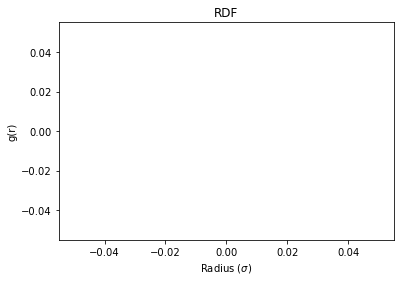

In [40]:
nn = 0
ng = 0
t = 0
gr = np.zeros(60)
uEplot = []
kEplot = []
Etplot = []
templot = []
time = []
# Main loop for all time steps
while t <= (dt * mdts):
    # Updating positions according to the velocity Verlet algorithm
    p += (dt * v) + ((dt ** 2) * at / 2)
        # Compute differences
    for i in range(N - 1):
        for j in range(i + 1, N):
            rx[i, j] = p[j, 0] - p[i, 0]
            ry[i, j] = p[j, 1] - p[i, 1]
            rz[i, j] = p[j, 2] - p[i, 2]
            rx[j, i] = -rx[i, j]
            ry[j, i] = -ry[i, j]
            rz[j, i] = -rz[i, j]
    # Compute differences
    #not working right
    # delta_xyz = p[:, np.newaxis, :] - p[np.newaxis, :, :]  
    # delta_xyz -= L * np.round(delta_xyz / L)
    rx = delta_xyz[:, :, 0]
    ry = delta_xyz[:, :, 1]
    rz = delta_xyz[:, :, 2]
    rx -= L * np.round(rx / L)
    ry -= L * np.round(ry / L)
    rz -= L * np.round(rz / L)
    # Compute distances
    r = np.sqrt(rx**2 + ry**2 + rz**2)
    # Compute potential energy incrementally
    mask = ((r <= 2.5)& (r > 0))
    uE = np.sum(2 * ((1 / r[mask] ** 12) - (1 / r[mask] ** 6) - (1 / 2.5 ** 12) + (1 / 2.5 ** 6)))

    # Computing the new acceleration
    for i in range(N):
        Atem = np.zeros(3)
        for j in range(N):
            if (r[i, j] > 0 and r[i, j] <= 2.5):
                factor = (24 / r[i, j]) * (2 * (1 / r[i, j]** 12) - (1 / r[i, j]** 6))
                Atem[0] += factor * (-rx[i, j] / r[i, j])
                Atem[1] += factor * (-ry[i, j] / r[i, j])
                Atem[2] += factor * (-rz[i, j] / r[i, j])

        atdt[i, 0] = Atem[0]
        atdt[i, 1] = Atem[1]
        atdt[i, 2] = Atem[2]

    # Updating velocities according to the velocity Verlet algorithm
    v += dt * (at + atdt) / 2
    vi_squared = np.sum(v**2, axis=1)
    ktd = np.sum(vi_squared)

    # Calculating RDF in several time steps
    if ((nn % 10 == 0) and (nn > 500)):
        ng += 1
        for i in range(1, 61):
            mask = np.logical_and(r <= i * dr, r > (i - 1) * dr)
            sp = np.sum(np.triu(mask, k=1))
            gr[i - 1] += sp * 3 * L ** 3 / (2 * np.pi * N * (N - 1) * ((i * dr) ** 3 - ((i - 1) * dr) ** 3))

    # Rescaling velocity in first 500 steps
    if nn < 500:
        cf = np.sqrt((3 * N * T) / ktd)
        v *= cf
        vi_squared = np.sum(v**2, axis=1)
        ktd = np.sum(vi_squared)
    # Computing kinetic energy and temperature
    kE = ktd / 2
    T = ktd / (3 * N)
    # Replacing old acceleration by new acceleration
    at = atdt

    # Computing the total energy
    Et = uE + kE
    t += dt
    nn += 1

    # Printing the energies and temperatures in a text file
    # print(f"time:{t} Kt:{kE} Ut:{uE} E:{Et} T:{T}\n")
    uEplot.append(uE)
    kEplot.append(kE)
    Etplot.append(Et)
    templot.append(T)
    time.append(t)


# Printing final average RDF in the text file
gr = gr / ng
# Plotting RDF
plt.figure(figsize=(8,5))
plt.plot(Radius, gr)
plt.title('Final RDF')
plt.xlabel('Radius ($\sigma$)')
plt.ylabel('g(r)')
plt.show()

# Plotting the simulation box
fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pold[:, 0], pold[:, 1], pold[:, 2], s=13, c='black')
ax.set_title('Simulation Box')




In [41]:
v.max()

49.411114921397505

In [42]:
vv

NameError: name 'vv' is not defined

In [ ]:
d = 0
cnt = 0
t = 0
gr = np.zeros(60)
# Main loop for all time steps
while t <= (dt * mdts):
    uE=0
    # Updating positions according to the velocity Verlet algorithm
    p += (dt * v) + ((dt ** 2) * at / 2)
    # Compute differences
    for i in range(N - 1):
        for j in range(i + 1, N):
            rx[i, j] = p[j, 0] - p[i, 0]
            ry[i, j] = p[j, 1] - p[i, 1]
            rz[i, j] = p[j, 2] - p[i, 2]
            rx[i, j] -= L * np.round(rx[i, j] / L)
            ry[i, j] -= L * np.round(ry[i, j] / L)
            rz[i, j] -= L * np.round(rz[i, j] / L)

            r[i, j] = np.sqrt(rx[i, j] ** 2 + ry[i, j] ** 2 + rz[i, j] ** 2)
            rx[j, i] = -rx[i, j]
            ry[j, i] = -ry[i, j]
            rz[j, i] = -rz[i, j]
            r[j, i] = r[i, j]

            if r[i, j] <= 2.5:
                uE += 4 * ((1 / r[i, j] ** 12) - 1 / r[i, j] ** 6 - (1 / 2.5 ** 12) + 1 / 2.5 ** 6)

    # Computing the new acceleration
    for i in range(N):
        Atem = np.zeros(3)
        for j in range(N):
            if r[i, j] > 0 and r[i, j] <= 2.5:
                factor = (24 / r[i, j]) * (2 * (1 / r[i, j]) ** 12 - (1 / r[i, j]) ** 6)
                Atem[0] += factor * (-rx[i, j] / r[i, j])
                Atem[1] += factor * (-ry[i, j] / r[i, j])
                Atem[2] += factor * (-rz[i, j] / r[i, j])

        atdt[i, 0] = Atem[0]
        atdt[i, 1] = Atem[1]
        atdt[i, 2] = Atem[2]

    # Updating velocities according to the velocity Verlet algorithm
    v += dt * (at + atdt) / 2
    vi_squared = np.sum(v**2, axis=1)
    ktd = np.sum(vi_squared)

    # Calculating RDF in several time steps
    if ((d % 10 == 0) and (d > 500)):
        cnt += 1
        for i in range(1, 61):
            mask = np.logical_and(r <= i * dr, r > (i - 1) * dr)
            sp = np.sum(np.triu(mask, k=1))
            gr[i - 1] += sp * 3 * L ** 3 / (2 * np.pi * N * (N - 1) * ((i * dr) ** 3 - ((i - 1) * dr) ** 3))

    # Rescaling velocity in first 500 steps
    if d < 50:
        cf = np.sqrt((3 * N * T) / ktd)
        v *= cf
        vi_squared = np.sum(v**2, axis=1)
        ktd = np.sum(vi_squared)


    # Computing kinetic energy and temperature
    kE = ktd / 2
    T = ktd / (3 * N)

    # Replacing old acceleration by new acceleration
    at = atdt

    # Computing the total energy
    Et = uE + kE

    # Printing the energies and temperatures in a text file
    print(f"time:{t} Kt:{kE} Ut:{uE} E:{Et} T:{T}\n")

    t += dt
    d += 1

# Printing final average RDF in the text file
gr = gr / cnt
# Plotting RDF
plt.figure()
plt.plot(Radius, gr)
plt.title('RDF')
plt.xlabel('Radius ($\sigma$)')
plt.ylabel('g(r)')
plt.show()

time:0 Kt:2527.499999999999 Ut:-5385.983841361585 E:-2858.483841361586 T:1.2499999999999996

time:0.003 Kt:2527.499999999999 Ut:-5359.931163376479 E:-2832.43116337648 T:1.2499999999999996

time:0.006 Kt:2527.499999999998 Ut:-5317.322776321056 E:-2789.822776321058 T:1.2499999999999991

time:0.009000000000000001 Kt:2527.4999999999977 Ut:-5259.294079256486 E:-2731.794079256488 T:1.249999999999999

time:0.012 Kt:2527.4999999999973 Ut:-5187.365477589285 E:-2659.8654775892874 T:1.2499999999999987

time:0.015 Kt:2527.499999999998 Ut:-5103.588496745056 E:-2576.0884967450575 T:1.2499999999999991

time:0.018 Kt:2527.4999999999977 Ut:-5010.593683257433 E:-2483.0936832574357 T:1.249999999999999

time:0.020999999999999998 Kt:2527.499999999998 Ut:-4911.533953675726 E:-2384.0339536757274 T:1.2499999999999991

time:0.023999999999999997 Kt:2527.4999999999977 Ut:-4809.9394425446235 E:-2282.4394425446258 T:1.249999999999999

time:0.026999999999999996 Kt:2527.499999999998 Ut:-4709.439631563322 E:-2181.939

KeyboardInterrupt: 

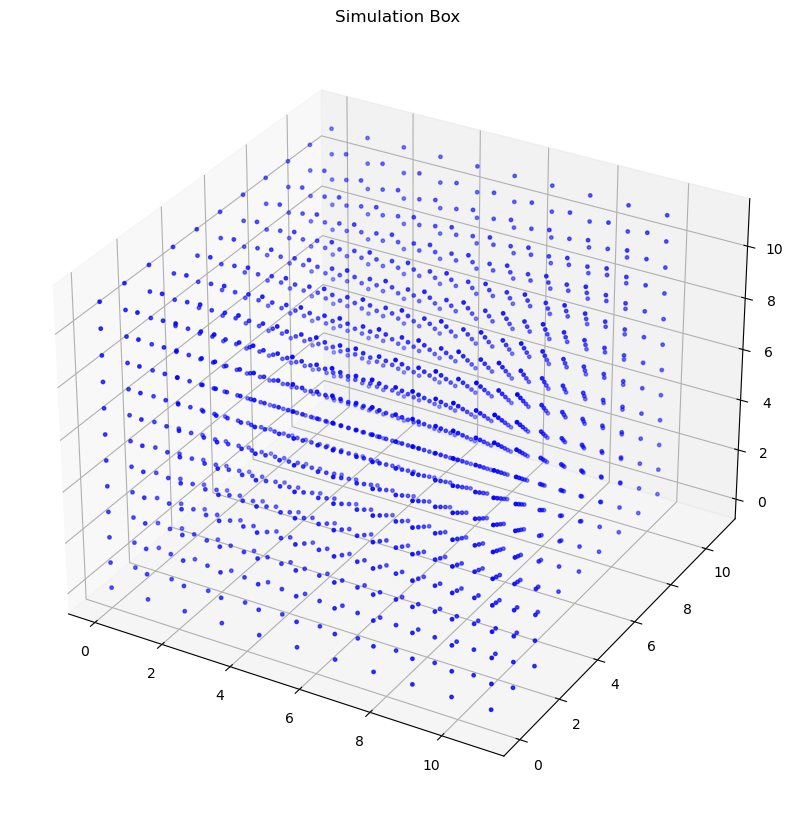

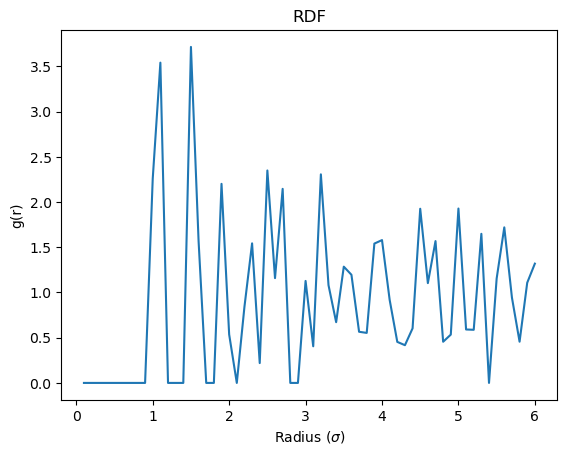

g(r):  [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]


C:\Users\Moein\AppData\Local\Temp\ipykernel_1876\3712043758.py:170: RuntimeWarning: invalid value encountered in divide
  gr = gr / cnt


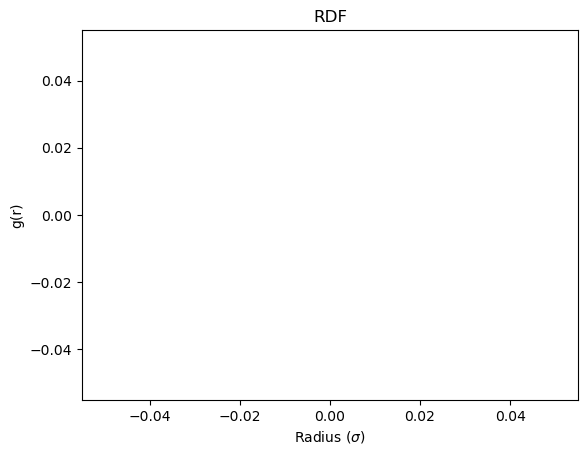

In [ ]:
# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

L = 12  # length of cell
N = 1348  # number of atoms
mdts = 0.03 # number of time steps
dt = 0.003  # time step
dr = 0.1  # delta r for RDF
T = 1.25  # temperature

p = np.zeros((N, 3))
# Generate regular initial locations of each particle in the cell
nop = 0
for x in range(11):
    for y in range(11):
        for z in range(12):
            if nop < N:
                p[nop] = np.array([x * 1.091, y * 1.091, z])
                nop += 1
# Plotting the simulation box
fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p[:, 0], p[:, 1], p[:, 2], s=6, c='b')
ax.set_title('Simulation Box')

# %%
np.random.seed(0)  # Seed for reproducibility

# give an initial velocity to all
v = np.random.rand(N, 3) - 0.5
vi_squared = np.sum(v**2, axis=1)
ktd = np.sum(vi_squared)
# Correction of initial velocity
cf = np.sqrt((3 * N * T) / ktd)
v *= cf

# Compute differences
delta_xyz = p[:, None, :] - p[None, :, :]
delta_xyz -= L * np.round(delta_xyz / L)

rx = delta_xyz[:, :, 0]
ry = delta_xyz[:, :, 1]
rz = delta_xyz[:, :, 2]

# Compute distances
r = np.sqrt(rx**2 + ry**2 + rz**2)

# Compute potential energy incrementally
mask = np.logical_and((r <= 2.5),(r>0))
uE = np.sum(2 * ((1 / r[mask] ** 12) - 1 / r[mask] ** 6 - (1 / 2.5 ** 12) + 1 / 2.5 ** 6))

# Calculate the number of atom at different radius
Radius = np.arange(0.1, 6.1, 0.1)
grinit = np.zeros(60)
for i in range(1, 61):
    mask = np.logical_and(r <= i * dr, r > (i - 1) * dr)
    sp = np.sum(np.triu(mask, k=1))
    grinit[i - 1] = sp * 3 * L ** 3 / (2 * np.pi * N * (N - 1) * ((i * dr) ** 3 - ((i - 1) * dr) ** 3))
        
# Plotting RDF
plt.figure()
plt.plot(Radius, grinit)
plt.title('RDF')
plt.xlabel('Radius ($\sigma$)')
plt.ylabel('g(r)')
plt.show()

at = np.zeros((N, 3))
atdt = np.zeros((N, 3))

for i in range(N):
    Atem = np.zeros(3)
    for j in range(N):
        if r[i, j] > 0 and r[i, j] <= 2.5:
            factor = (24 / r[i, j]) * (2 * (1 / r[i, j]) ** 12 - (1 / r[i, j]) ** 6)
            Atem[0] += factor * (-rx[i, j] / r[i, j])
            Atem[1] += factor * (-ry[i, j] / r[i, j])
            Atem[2] += factor * (-rz[i, j] / r[i, j])

    at[i, 0] = Atem[0]
    at[i, 1] = Atem[1]
    at[i, 2] = Atem[2]

# %%
result = []
d = 0
cnt = 0
t = 0
gr = np.zeros(60)
# Main loop for all time steps
while t <= (dt * mdts):
    uE=0
    # Updating positions according to the velocity Verlet algorithm
    p += (dt * v) + ((dt ** 2) * at / 2)
    # Compute differences
    for i in range(N - 1):
        for j in range(i + 1, N):
            rx[i, j] = p[j, 0] - p[i, 0]
            ry[i, j] = p[j, 1] - p[i, 1]
            rz[i, j] = p[j, 2] - p[i, 2]
            rx[i, j] -= L * np.round(rx[i, j] / L)
            ry[i, j] -= L * np.round(ry[i, j] / L)
            rz[i, j] -= L * np.round(rz[i, j] / L)

            r[i, j] = np.sqrt(rx[i, j] ** 2 + ry[i, j] ** 2 + rz[i, j] ** 2)
            rx[j, i] = -rx[i, j]
            ry[j, i] = -ry[i, j]
            rz[j, i] = -rz[i, j]
            r[j, i] = r[i, j]

            if r[i, j] <= 2.5:
                uE += 4 * ((1 / r[i, j] ** 12) - 1 / r[i, j] ** 6 - (1 / 2.5 ** 12) + 1 / 2.5 ** 6)

    # Computing the new acceleration
    for i in range(N):
        Atem = np.zeros(3)
        for j in range(N):
            if r[i, j] > 0 and r[i, j] <= 2.5:
                factor = (24 / r[i, j]) * (2 * (1 / r[i, j]) ** 12 - (1 / r[i, j]) ** 6)
                Atem[0] += factor * (-rx[i, j] / r[i, j])
                Atem[1] += factor * (-ry[i, j] / r[i, j])
                Atem[2] += factor * (-rz[i, j] / r[i, j])

        atdt[i, 0] = Atem[0]
        atdt[i, 1] = Atem[1]
        atdt[i, 2] = Atem[2]

    # Updating velocities according to the velocity Verlet algorithm
    v += dt * (at + atdt) / 2
    vi_squared = np.sum(v**2, axis=1)
    ktd = np.sum(vi_squared)

    # Calculating RDF in several time steps
    if ((d % 1 == 0) and (d > 0)):
        cnt += 1
        for i in range(1, 61):
            mask = np.logical_and(r <= i * dr, r > (i - 1) * dr)
            sp = np.sum(np.triu(mask, k=1))
            gr[i - 1] += sp * 3 * L ** 3 / (2 * np.pi * N * (N - 1) * ((i * dr) ** 3 - ((i - 1) * dr) ** 3))

    # Rescaling velocity in first 500 steps
    if d < 500:
        cf = np.sqrt((3 * N * T) / ktd)
        v *= cf
        vi_squared = np.sum(v**2, axis=1)
        ktd = np.sum(vi_squared)


    # Computing kinetic energy and temperature
    kE = ktd / 2
    T = ktd / (3 * N)

    # Replacing old acceleration by new acceleration
    at = atdt

    # Computing the total energy
    Et = uE + kE

    # results
    result.append([t, Et, kE, uE, T])
    

    t += dt
    d += 1
df = pd.DataFrame(result, columns = ['time', 'Et', 'KE', 'UE','T'])
df.to_excel(excel_writer =  'GEOMETRYDETAILS.xlsx')
# Printing final average RDF in the text file
gr = gr / cnt
print:('radius:', Radius)
print('g(r): ', gr)

# Plotting RDF
plt.figure()
plt.plot(Radius, gr)
plt.title('RDF')
plt.xlabel('Radius ($\sigma$)')
plt.ylabel('g(r)')
plt.show()


